<a href="https://colab.research.google.com/github/NathanaelAP/FinalProjectDatmin/blob/main/Copy_of_Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --target=$nb_path xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')

## Import Library

In [ ]:
import twint as tw
import nest_asyncio
import pandas as pd
import numpy as np
import itertools, re, nltk
from textblob import TextBlob
from html import unescape
from unidecode import unidecode
import networkx as nx
import urllib
import json
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Karena kami sudah menarik data twitter dan sudah disimpan maka 
nest_asyncio.apply()
config = tw.Config()
config.Hide_output = True
config.Retweets = True
config.Pandas = True
config.Profile_full = True
config.Since = '2022-12-19'
config.Until = '2022-12-26'
config.Search = "piala dunia"
config.Limit = 12000

tw.run.Search(config)
data = tw.storage.panda.Tweets_df

data

[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.


,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1607164088999899136,1607164088999899136,1.672013e+12,2022-12-25 23:59:13,+0000,,Brazil mahu Mourinho Brazil merancang mendapat...,in,[],[],...,,,,,,[],,,,
1,1607163475851378689,1607163475851378689,1.672013e+12,2022-12-25 23:56:46,+0000,,Mustahil 12 bintang Piala Dunia Tottenham dapa...,in,[],[],...,,,,,,[],,,,
2,1607162565339279360,1607162565339279360,1.672012e+12,2022-12-25 23:53:09,+0000,,sebenernya engga siap harus nunggu 4 tahun unt...,in,[],[],...,,,,,,[],,,,
3,1607162139445465088,1607162139445465088,1.672012e+12,2022-12-25 23:51:28,+0000,,Berkat kasih ibu pacu kejayaan Maghribi di Pia...,in,[],[],...,,,,,,[],,,,
4,1607161997917065217,1607161997917065217,1.672012e+12,2022-12-25 23:50:54,+0000,,Bola dan sepatu buatan Indonesia digunakan u...,in,[],[],...,,,,,,[],,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11616,1604964321964228608,1604964321964228608,1.671488e+12,2022-12-19 22:18:07,+0000,,"Bawa Argentina Juara Piala Dunia 2022, Ini Der...",in,[temposport],[],...,,,,,,[],,,,
11617,1604963894178754560,1604963894178754560,1.671488e+12,2022-12-19 22:16:25,+0000,,pas piala dunia aku dukung brasil kamu dukung ...,in,[],[],...,,,,,,[],,,,
11618,1604963777006522388,1604963777006522388,1.671488e+12,2022-12-19 22:15:57,+0000,,Piala Dunia dan Qiyas dalam Kisah Maroko http...,in,[],[],...,,,,,,[],,,,
11619,1604963675210936321,1604963675210936321,1.671488e+12,2022-12-19 22:15:33,+0000,,Chef Salt Bae Banjir Kecaman Usai Pegang Trofi...,in,[],[],...,,,,,,[],,,,


In [ ]:
df = data[data['language'] == 'in']
df = df.drop_duplicates(subset=['tweet']).reset_index(drop=True)

In [ ]:
# Simpan data hasil scrapping yang belum di cleansing

# df.to_csv('data_twitter.csv', index=False)

In [ ]:
sastrawi_stopwords = StopWordRemoverFactory().get_stop_words()
stemmer = StemmerFactory().create_stemmer()

In [ ]:
# Handling kata slang/typo
slang = urllib.request.urlopen('https://raw.githubusercontent.com/louisowen6/NLP_bahasa_resources/master/combined_slang_words.txt')
slang = json.loads(slang.read())
slang['apik'] = 'indah'
slang['anjeng'] = 'anjing'
slang['baheula'] = 'dulu'
slang['sangaaaat'] = 'sangat'
slang['rusakkk'] = 'rusak'
slang['gada'] = 'tidak ada'
slang['gaada'] = 'tidak ada'
slang['gak'] = 'tidak'
slang['akeh'] = 'banyak'
slang['nggacor'] = 'hebat'
print(slang)

{'@': 'di', 'abis': 'habis', 'ad': 'ada', 'adlh': 'adalah', 'afaik': 'as far as i know', 'ahaha': 'haha', 'aj': 'saja', 'ajep-ajep': 'dunia gemerlap', 'ak': 'saya', 'akika': 'aku', 'akkoh': 'aku', 'akuwh': 'aku', 'alay': 'norak', 'alow': 'halo', 'ambilin': 'ambilkan', 'ancur': 'hancur', 'anjrit': 'anjing', 'anter': 'antar', 'ap2': 'apa-apa', 'apasih': 'apa sih', 'apes': 'sial', 'aps': 'apa', 'aq': 'saya', 'aquwh': 'aku', 'asbun': 'asal bunyi', 'aseekk': 'asyik', 'asekk': 'asyik', 'asem': 'asam', 'aspal': 'asli tetapi palsu', 'astul': 'asal tulis', 'ato': 'atau', 'au ah': 'tidak mau tahu', 'awak': 'saya', 'ay': 'sayang', 'ayank': 'sayang', 'b4': 'sebelum', 'bakalan': 'akan', 'bandes': 'bantuan desa', 'bangedh': 'banget', 'banpol': 'bantuan polisi', 'banpur': 'bantuan tempur', 'basbang': 'basi', 'bcanda': 'bercanda', 'bdg': 'bandung', 'begajulan': 'nakal', 'beliin': 'belikan', 'bencong': 'banci', 'bentar': 'sebentar', 'ber3': 'bertiga', 'beresin': 'membereskan', 'bete': 'bosan', 'beud': 

## Sentiment Analysis and Classification

### Preprocessing Sentiment Analysis

In [ ]:
# Membuat function cleanText untuk Cleaning Text yang akan digunakan dalam Sentiment Analysis
def cleanText(txt):
    docx = unidecode(unescape(txt.lower().strip()))
    urlPattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    docx = re.sub(urlPattern,' ', docx) # Remove links
    docx = re.sub(r'[^\w]', ' ', docx) # Remove Symbol, keep "_" ... recommended
    docx = stemmer.stem(docx)
    docx = TextBlob(docx).words
    
    for i, n in enumerate(docx): # Remove Slang
      if n in slang.keys():
        docx[i] = slang[n]
    docx = ' '.join(docx)

    return docx

In [ ]:
# Apply function cleanText terhadap kolom tweet dan disimpan ke kolom baru clean_tweet

# df['clean_tweet'] = df['tweet'].apply(cleanText)

In [ ]:
# Mengambil kolom clean_tweet untuk keperluan sentimen

# tweet = df[['clean_tweet']]

In [ ]:
# Hanya 3750 data yang di partisi menjadi 4 bagian dikarenakan terdapat limit 
# dalam translate menggunakan TextBlob

# tweet1 = tweet.iloc[:1000, :]
# tweet2 = tweet.iloc[1000:2000, :]
# tweet3 = tweet.iloc[2000:3000, :]
# tweet4 = tweet.iloc[3000:3750, :]

In [ ]:
# Membuat function score untuk mendapatkan score polarity

def score(txt):
  analysis = TextBlob(txt)
  an = analysis.translate(from_lang='id', to='en')
  return an.sentiment

In [ ]:
# Apply function score terhadap 4 partisi yang sudah dibuat sebelumnya

# tweet1['polarity'] = tweet1['clean_tweet'].apply(lambda x: score(x)[0])
# tweet2['polarity'] = tweet2['clean_tweet'].apply(lambda x: score(x)[0])
# tweet3['polarity'] = tweet3['clean_tweet'].apply(lambda x: score(x)[0])
# tweet4['polarity'] = tweet4['clean_tweet'].apply(lambda x: score(x)[0])

In [ ]:
# Menggabungkan 4 partisi data yang sudah diberi score polarity

# sentiment = pd.concat([tweet1, tweet2, tweet3, tweet4], axis=0)

In [ ]:
# Membuat variabel remind_tweet untuk menyimpan sisa data yang belum di translate 
# dan diberi score polarity untuk di label sentimen manual

# remind_tweet = tweet.iloc[3750:, :]
# remind_tweet.to_csv('remind_tweet.csv', index=False)

In [ ]:
# membuat function sentiment untuk mendapatkan nilai sentiment

def sentiment(pol):
  if pol > 0:
    return 1 # Positif
  elif pol < 0:
    return 0 # Negatif
  else:
    return 2 # Netral

# Apply function sentiment terhadap kolom polarity

# sentiment['sentiment'] = sentiment['polarity'].apply(sentiment)

<ipython-input-46-bc460c8a8cd7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ab['sentiment'] = ab['polarity'].apply(sentiment)


In [ ]:
# sentiment = sentiment[['clean_tweet', 'sentiment']]

In [ ]:
# sentiment.to_csv('sentiment(3750).csv', index=False)

In [ ]:
# Import Data yang sudah di label sentiment
sentiment_3750 = pd.read_csv('https://raw.githubusercontent.com/ranggabuwana/data-mining/main/sentiment(3750).csv')
remind_tweet = pd.read_csv('https://raw.githubusercontent.com/ranggabuwana/data-mining/main/remind_tweet.csv')

In [ ]:
tweet_sentiment = pd.concat([sentiment_3750, remind_tweet], axis=0)
clean_tweet = tweet_sentiment[['clean_tweet']]

In [ ]:
# clean_tweet.to_csv('clean_tweet.txt', index=False, encoding='utf8', header=False)

### Exploratory Data Analysis

### WordCloud

In [ ]:
stopwords = ['di', 'ke', 'dari', 'yang', 'dan', 'untuk', 'dengan', 'pada', 'ini', 'itu','piala','dunia', 'tidak']

def remove_stopwords(text):
    # Split teks menjadi list kata
    words = text.split()
    # Buang kata-kata dalam daftar stopword
    filtered_words = [word for word in words if word not in stopwords]
    # Gabungkan kembali list kata menjadi string
    return " ".join(filtered_words)

# Terapkan fungsi pada dataframe
tweet_sentiment['clean_tweet'] = tweet_sentiment['clean_tweet'].apply(remove_stopwords)

tweet_sentiment

                                            clean_tweet  sentiment
0     brazil mahu mourinho brazil rancang dapat khid...        2.0
1     mustahil 12 bintang tottenham dapat cukup reha...        0.0
2      sebenernya engga siap harus nunggu 4 tahun th th        0.0
3                   berkat kasih ibu pacu jaya maghribi        1.0
4                       bola sepatu buat indonesia guna        2.0
...                                                 ...        ...
7051  para penggawa timnas maroko sama ibu temu raja...        1.0
7052  isi whatsapp angel maria jelang final bikin pe...        2.0
7053  foto timnas argentina gelar parade menang juar...        2.0
7054  menteri bumn pak erick thohir et sayang jokowi...        1.0
7055  timnas maroko tampil gemilang 2022 hasil lanta...        1.0

[10806 rows x 2 columns]


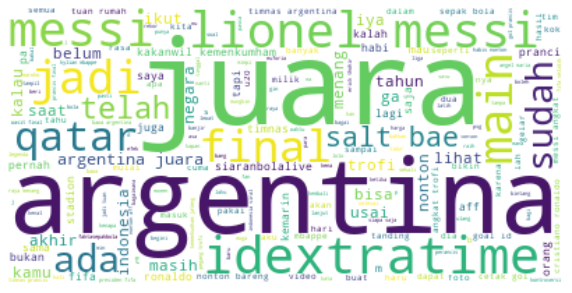

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#Visualisasi netral
data_all = tweet_sentiment[tweet_sentiment["sentiment"] == 2]
WC = WordCloud(background_color = 'white').generate(data_all['clean_tweet'].to_string())
plt.figure(figsize=(10,10))
plt.imshow(WC, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

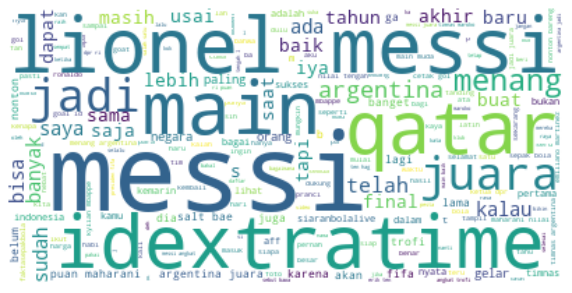

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#Visualisasi positif
data_all = tweet_sentiment[tweet_sentiment["sentiment"] == 1]
WC = WordCloud(background_color = 'white').generate(data_all['clean_tweet'].to_string())
plt.figure(figsize=(10,10))
plt.imshow(WC, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

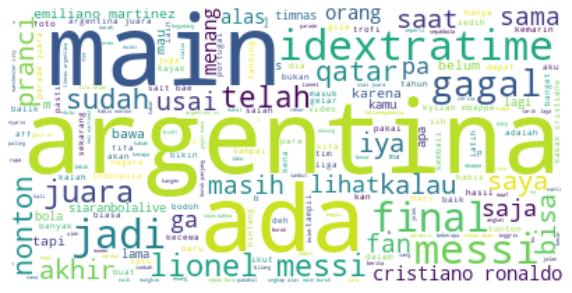

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#Visualisasi negatif
data_all = tweet_sentiment[tweet_sentiment["sentiment"] == 0]
WC = WordCloud(background_color = 'white').generate(data_all['clean_tweet'].to_string())
plt.figure(figsize=(10,10))
plt.imshow(WC, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

#### Sentiment Classification

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
# ros.fit(tweet_sentiment[['clean_tweet']], tweet_sentiment[['sentiment']])
X_resample, y_resample = ros.fit_resample(tweet_sentiment[['clean_tweet']], tweet_sentiment[['sentiment']])

tweet_resample = pd.concat([X_resample, y_resample], axis=1)

In [ ]:
tweet_resample

,clean_tweet,sentiment
0,brazil mahu mourinho brazil rancang dapat khid...,2.0
1,mustahil 12 bintang piala dunia tottenham dapa...,0.0
2,sebenernya engga siap harus nunggu 4 tahun unt...,0.0
3,berkat kasih ibu pacu jaya maghribi di piala d...,1.0
4,bola dan sepatu buat indonesia guna untuk pial...,2.0
...,...,...
15022,gol mario kempes pada final piala dunia 1978 d...,2.0
15023,pada piala dunia 1998 para main timnas rumania...,2.0
15024,stadion piala dunia ini bos senggol dong hujan...,2.0
15025,idextratime mana iya tum pssi kok gk ada waktu...,2.0


In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

# X_train, X_test, y_train, y_test = train_test_split(tweet_sentiment["clean_tweet"], tweet_sentiment["sentiment"], 
#                                                     test_size=0.3, random_state = 22)


# CV = 5
# metric = 'accuracy'
# params = {}
# params['tfidfvectorizer__min_df'] = [5, 10, 15]
# params['tfidfvectorizer__max_df'] = [0.5, 0.75, 0.95]
# params['tfidfvectorizer__smooth_idf'] = [True] # [True, False]
# params['tfidfvectorizer__sublinear_tf'] = [True] # [True, False]
# params['tfidfvectorizer__ngram_range'] = [(1, 1), (1, 2), (1,3)]
# params['randomforestclassifier__n_estimators'] = [500, 800, 1000]
# params['randomforestclassifier__max_depth'] = [5, 10, 20]

# gridCV_rf = HalvingGridSearchCV(make_pipeline(TfidfVectorizer(), RandomForestClassifier()),
#                          params, cv=CV, scoring=metric, verbose=1, n_jobs=-1)
# gridCV_rf.fit(X_train, y_train)
# print(gridCV_rf.best_score_)
# print(gridCV_rf.best_params_)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 93
max_resources_: 7564
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 243
n_resources: 93
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
----------
iter: 1
n_candidates: 81
n_resources: 279
Fitting 5 folds for each of 81 candidates, totalling 405 fits
----------
iter: 2
n_candidates: 27
n_resources: 837
Fitting 5 folds for each of 27 candidates, totalling 135 fits
----------
iter: 3
n_candidates: 9
n_resources: 2511
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 4
n_candidates: 3
n_resources: 7533
Fitting 5 folds for each of 3 candidates, totalling 15 fits
0.6927872121701455
{'randomforestclassifier__max_depth': 20, 'randomforestclassifier__n_estimators': 800, 'tfidfvectorizer__max_df': 0.95, 'tfidfvectorizer__min_df': 10, 'tfidfvectorizer__ngram_range': (1, 1), 'tfidfvectorizer__smooth_idf': True, 'tfidfvectorizer__sublinear_tf': T

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(tweet_sentiment["clean_tweet"], tweet_sentiment["sentiment"], 
                                                    test_size=0.3, random_state = 22)

tfidf = TfidfVectorizer(max_df=0.95, min_df=10, ngram_range=(1,1), smooth_idf=True, sublinear_tf=True)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

def hapusKosong(X,Y):
    Y = Y[X.getnnz(1)>0] 
    X = X[X.getnnz(1)>0] 
    return X, Y

X_train, y_train = hapusKosong(X_train, y_train)
X_test, y_test = hapusKosong(X_test, y_test)

rf = RandomForestClassifier(n_estimators=800, max_depth=20, random_state=22)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_score = accuracy_score(y_test, rf_pred)
print(confusion_matrix(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

[[  67  257  149]
 [   3 1221  237]
 [   1  303  995]]
              precision    recall  f1-score   support

         0.0       0.94      0.14      0.25       473
         1.0       0.69      0.84      0.75      1461
         2.0       0.72      0.77      0.74      1299

    accuracy                           0.71      3233
   macro avg       0.78      0.58      0.58      3233
weighted avg       0.74      0.71      0.67      3233



In [ ]:
# Adaptive Boosting Classifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, train_test_split
from sklearn.ensemble import AdaBoostClassifier

# X_train, X_test, y_train, y_test = train_test_split(tweet_sentiment["clean_tweet"], tweet_sentiment["sentiment"], 
#                                                     test_size=0.3, random_state = 22)

# CV = 5
# metric = 'accuracy'
# params = {}
# params['tfidfvectorizer__min_df'] = [5, 10, 15]
# params['tfidfvectorizer__max_df'] = [0.5, 0.75, 0.95]
# params['tfidfvectorizer__smooth_idf'] = [True] # [True, False]
# params['tfidfvectorizer__sublinear_tf'] = [True] # [True, False]
# params['tfidfvectorizer__ngram_range'] = [(1, 1), (1, 2), (1,3)]
# params['adaboostclassifier__n_estimators'] = [500, 800, 1000]
# params['adaboostclassifier__learning_rate'] = [0.5, 1.0, 1.5]

# gridCV_ada = HalvingGridSearchCV(make_pipeline(TfidfVectorizer(), AdaBoostClassifier()),
#                          params, cv=CV, scoring=metric, verbose=1, n_jobs=-1)
# gridCV_ada.fit(X_train, y_train)
# print(gridCV_ada.best_score_)
# print(gridCV_ada.best_params_)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 93
max_resources_: 7564
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 162
n_resources: 93
Fitting 5 folds for each of 162 candidates, totalling 810 fits
----------
iter: 1
n_candidates: 54
n_resources: 279
Fitting 5 folds for each of 54 candidates, totalling 270 fits
----------
iter: 2
n_candidates: 18
n_resources: 837
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 3
n_candidates: 6
n_resources: 2511
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 4
n_candidates: 2
n_resources: 7533
Fitting 5 folds for each of 2 candidates, totalling 10 fits
0.7058048205847705
{'adaboostclassifier__learning_rate': 0.5, 'adaboostclassifier__n_estimators': 800, 'tfidfvectorizer__max_df': 0.5, 'tfidfvectorizer__min_df': 10, 'tfidfvectorizer__ngram_range': (1, 1), 'tfidfvectorizer__smooth_idf': True, 'tfidfvectorizer__sublinear_tf': True}


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import AdaBoostClassifier

X_train, X_test, y_train, y_test = train_test_split(tweet_sentiment["clean_tweet"], tweet_sentiment["sentiment"], 
                                                    test_size=0.3, random_state = 22)

tfidf = TfidfVectorizer(max_df=0.5, min_df=10, ngram_range=(1,1), smooth_idf=True, sublinear_tf=True)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

def hapusKosong(X,Y):
    Y = Y[X.getnnz(1)>0] 
    X = X[X.getnnz(1)>0] 
    return X, Y

X_train, y_train = hapusKosong(X_train, y_train)
X_test, y_test = hapusKosong(X_test, y_test)

ada = AdaBoostClassifier(n_estimators=800, learning_rate=0.5, random_state=22)

ada.fit(X_train, y_train)
ada_pred = ada.predict(X_test)
ada_score = accuracy_score(y_test, ada_pred)
print(confusion_matrix(y_test, ada_pred))
print(classification_report(y_test, ada_pred))

[[ 152  173  148]
 [  45 1080  336]
 [  39  210 1050]]
              precision    recall  f1-score   support

         0.0       0.64      0.32      0.43       473
         1.0       0.74      0.74      0.74      1461
         2.0       0.68      0.81      0.74      1299

    accuracy                           0.71      3233
   macro avg       0.69      0.62      0.64      3233
weighted avg       0.70      0.71      0.69      3233



In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, train_test_split
from xgboost import XGBClassifier

# X_train, X_test, y_train, y_test = train_test_split(tweet_sentiment["clean_tweet"], tweet_sentiment["sentiment"], 
#                                                     test_size=0.3, random_state = 22)

# CV = 5
# metric = 'accuracy'
# params = {}
# params['tfidfvectorizer__min_df'] = [5, 10, 15]
# params['tfidfvectorizer__max_df'] = [0.5, 0.75, 0.95]
# params['tfidfvectorizer__smooth_idf'] = [True] # [True, False]
# params['tfidfvectorizer__sublinear_tf'] = [True] # [True, False]
# params['tfidfvectorizer__ngram_range'] = [(1, 1), (1, 2), (1,3)]
# params['xgbclassifier__validate_parameters'] = [True]
# params['xgbclassifier__learning_rate'] = [0.3, 0.5, 0.8]

# gridCV_xgb = HalvingGridSearchCV(make_pipeline(TfidfVectorizer(), XGBClassifier()),
#                          params, cv=CV, scoring=metric, verbose=1, n_jobs=-1)
# gridCV_xgb.fit(X_train, y_train)
# print(gridCV_xgb.best_score_)
# print(gridCV_xgb.best_params_)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 93
max_resources_: 7564
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 81
n_resources: 93
Fitting 5 folds for each of 81 candidates, totalling 405 fits
----------
iter: 1
n_candidates: 27
n_resources: 279
Fitting 5 folds for each of 27 candidates, totalling 135 fits
----------
iter: 2
n_candidates: 9
n_resources: 837
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 3
n_candidates: 3
n_resources: 2511
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 4
n_candidates: 1
n_resources: 7533
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.7310403127247378
{'tfidfvectorizer__max_df': 0.95, 'tfidfvectorizer__min_df': 5, 'tfidfvectorizer__ngram_range': (1, 2), 'tfidfvectorizer__smooth_idf': True, 'tfidfvectorizer__sublinear_tf': True, 'xgbclassifier__learning_rate': 0.3, 'xgbclassifier__validate_parameters': True}


In [ ]:
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(tweet_sentiment["clean_tweet"], tweet_sentiment["sentiment"], 
                                                    test_size=0.3, random_state = 22)

tfidf = TfidfVectorizer(max_df=0.95, min_df=5, ngram_range=(1,2), smooth_idf=True, sublinear_tf=True)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

def hapusKosong(X,Y):
    Y = Y[X.getnnz(1)>0] # delete label dokumen yang memiliki row =0 di tfidf-nya
    X = X[X.getnnz(1)>0] # Remove Zero Rows
    return X, Y

X_train, y_train = hapusKosong(X_train, y_train)
X_test, y_test = hapusKosong(X_test, y_test)

# pipe_xgb = make_pipeline(('tfidfvectorizer',TfidfVectorizer(max_df=0.95, min_df=5, ngram_range=(1,2), 
#                                                             smooth_idf=True, sublinear_tf=True)),
#                         ('xgbclassifier', XGBClassifier(learning_rate=0.3, validate_parameters=True)))

xgb = XGBClassifier(learning_rate=0.3, validate_parameters=True)

xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
xgb_score = accuracy_score(y_test, xgb_pred)
print(confusion_matrix(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))

[[ 170  157  146]
 [  21 1154  286]
 [  13  184 1104]]
              precision    recall  f1-score   support

         0.0       0.83      0.36      0.50       473
         1.0       0.77      0.79      0.78      1461
         2.0       0.72      0.85      0.78      1301

    accuracy                           0.75      3235
   macro avg       0.77      0.67      0.69      3235
weighted avg       0.76      0.75      0.74      3235



In [ ]:
accuracy = pd.DataFrame({'Model':['Random Forest Classifier', 'Adaptive Boost classifier',
                                  'XGBoost Classifier'],
                         'Score':[rf_score, ada_score, xgb_score]})
accuracy.sort_values('Score', ascending=False).reset_index(drop=True)

,Model,Score
0,XGBoost Classifier,0.750541
1,Random Forest Classifier,0.706155
2,Adaptive Boost classifier,0.705846


### Social Network Analysis

In [ ]:
df_sna = pd.read_csv('https://raw.githubusercontent.com/ranggabuwana/data-mining/main/data_twitter.csv')

In [ ]:
df_sna= df_sna[['username', 'tweet']]

In [ ]:
users = df_sna.username.to_list()
tweets = df_sna.tweet.to_list()

In [ ]:
G = nx.Graph()
G.add_nodes_from(users)

In [ ]:
for usr, t in zip(users, tweets):
    mentionS =  re.findall("@([a-zA-Z0-9]{1,15})", t)
    for mention in mentionS:
        if "." not in mention: #skipping emails
            G.add_edge(usr, mention)

In [ ]:
print('Banyak vertex = ', G.number_of_nodes())
print('Banyak Edges = ', G.number_of_edges())

Banyak vertex =  7532
Banyak Edges =  4852


In [ ]:
nx.write_gexf(G, "pildun.gexf")

In [ ]:
# Centrality Analysis

import operator

def Centrality(G, N=10, method='katz', outliers=False, Label = True, layOut='shells'):
    if method.lower()=='katz':
        phi = 1.618033988749895 # largest eigenvalue of adj matrix
        ranking = nx.katz_centrality_numpy(G,1/phi)
    elif method.lower() == 'degree':
        ranking = nx.degree_centrality(G)
    elif method.lower() == 'eigen':
        ranking = nx.eigenvector_centrality_numpy(G)
    elif method.lower() =='closeness':
        ranking = nx.closeness_centrality(G)
    elif method.lower() =='betweeness':
        ranking = nx.betweenness_centrality(G)
    elif method.lower() =='harmonic':
        ranking = nx.harmonic_centrality(G)
    elif method.lower() =='percolation':
        ranking = nx.percolation_centrality(G)
    else:
        print('Error, Unsupported Method.'); return None

    important_nodes = sorted(ranking.items(), key=operator.itemgetter(1))[::-1]#[0:Nimportant]
    data = np.array([n[1] for n in important_nodes])
    dnodes = [n[0] for n in important_nodes][:N]
    if outliers:
        m = 1 # 1 standard Deviation CI
        data = data[:N]
        out = len(data[abs(data - np.mean(data)) > m * np.std(data)]) # outlier within m stDev interval
        if out<N:
            dnodes = [n for n in dnodes[:out]]

    print('Influencial Users: {0}'.format(str(dnodes)))
    print('Influencial Users Scores: {0}'.format(str(data[:len(dnodes)])))
    Gt = G.subgraph(dnodes)
    return Gt

def drawGraph(G, Label, layOut='spring', graphStyle=False, K = 200):
    if graphStyle:
        ranking = nx.degree_centrality(G)
        warna = list(ranking.values())
        d = nx.degree(G)
        d = [d[node]*K for node in G.nodes()]
        pos = nx.spring_layout(G) # Spring LayOut
        nx.draw_networkx_nodes(G,pos, node_color=warna,node_size=d) # Gambar Vertex
        nx.draw_networkx_edges(G,pos,width=2,alpha=0.1) # Gambar edges
        nx.draw_networkx_labels(G,pos) #Gambar Label Nodes
        plt.show() # Show the graph
    else:
        if layOut.lower()=='spring':
            pos = nx.spring_layout(G)
        elif layOut.lower()=='circular':
            pos=nx.circular_layout(G)
        elif layOut.lower()=='random':
            pos = nx.random_layout(G)
        elif layOut.lower()=='shells':
            shells = [G.core_nodes,sorted(G.major_building_routers, 
                                          key=lambda n: nx.degree(G.topo, n)) + G.distribution_routers + G.server_nodes,G.hosts + G.minor_building_routers]
            pos = nx.shell_layout(G, shells)
        elif layOut.lower()=='spectral':
            pos=nx.spectral_layout(G)
        else:
            print('Graph Type is not available.')
            return
        nx.draw_networkx_nodes(G,pos, alpha=0.2,node_color='blue',node_size=600)
        if Label:
            nx.draw_networkx_labels(G,pos)
        nx.draw_networkx_edges(G,pos,width=4)
        plt.show()

#### Centrality By Degree

In [ ]:
Ct_d = Centrality(G, N=10, method='degree', outliers=False, Label = True, layOut='spring')

Influencial Users: ['idextratime', 'SiaranBolaLive', 'FaktaSepakbola', 'GOAL', 'registaco', 'PSSI', 'erickthohir', 'TumbalProyekk', 'jfelixdiaz', 'The']
Influencial Users Scores: [0.08086575 0.02044881 0.01155225 0.00929491 0.00531138 0.0051786
 0.00504581 0.00464746 0.00411632 0.00411632]


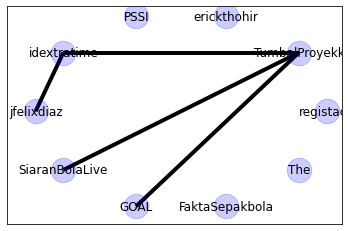

In [ ]:
drawGraph(Ct_d, True, layOut='circular')

#### Centrality by Closeneess

In [ ]:
Ct_close = Centrality(G, N=10, method='closeness', outliers=False, Label = True, layOut='spring')

Influencial Users: ['idextratime', 'HideTride', 'TumbalProyekk', 'maik23K', 'RevoNugroho', 'SepertiSalju', 'nextjack1995', 'dani_putra', 'woodysetiabudi', 'dian_oktariana']
Influencial Users Scores: [0.12278499 0.10361085 0.10265591 0.09992247 0.09967514 0.09917473
 0.09915595 0.09901529 0.09886569 0.0984381 ]


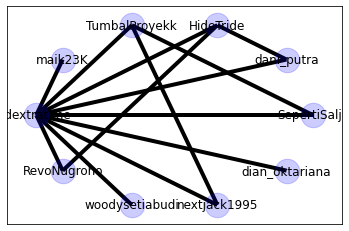

In [ ]:
drawGraph(Ct_close, True, layOut='circular')

#### Clustering Graph

In [ ]:
# Clustering pada Graph = Community Detection
cluster = nx.algorithms.community.greedy_modularity_communities(G)
for community in cluster:
    print(community)

frozenset({'Dahlah_Yere', 'bukanakunasliii', 'RizalMuharram', 'steveAndrew94', 'serizagenji', 'patriotj', 'IqbalQuosophy', 'EngineerASRS', 'nascamel', 'frizkiramadhani', 'alemgorat', 'Diyut__', 'anangga151', 'andreeputra', 'Ruuangsambat', 'ketoprak69', 'Cesc4Fahri', 'ARIeS_0016', 'bhagyabana', 'semangatrb', 'Gaotronaldo32', 'sadamgavin', 'myheropineapple', 'SIN_atR', 'DonquixoteM1ngo', 'KumalKabut', 'alltimemessi10', 'metalhed_awam', 'hrvione', 'lahhnm', 'hujanmangkok', 'ldynfi', 'itstaufann', 'noahmrs30', 'arfanaprilday', 'just922_', 'iimdzakir', 'SatriaS14398284', 'ordiinaryboyy', 'anwarzafran27', 'lilolegowo_', 'panda131100', 'FansnyaUta', 'SoundOfTalokan', 'AgustinusHerna3', 'bimoaditama25', 'YogiBoboy', 'arshavin2339', 'tokopedia', 'syaikh_syafiq', 'gtimamrmdhn', 'Sentuhan_Detail', 'abyaabyan', 'ghjklmn444', 'kholidfatur', 'adammalik01z', 'alterbanget_', 'KopitesRiswanto', 'idextratime', 'rifkifeb', 'Pengabdhi', 'anyway_football', 'akhmadyudo', 'arzeqnda', 'sulfancuk', 'Ltf_zz', '